In [ ]:
#env: sex_diff 
import pandas as pd
from itertools import combinations
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.stats import permutation_test
from sklearn.metrics.pairwise import cosine_similarity
from scipy.interpolate import make_interp_spline
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec, cm, colors, colormaps
import re
from statsmodels.stats.multitest import multipletests
from scipy.stats import spearmanr
import statsmodels.api as sm
from patsy import dmatrix
import matplotlib.lines as mlines
from matplotlib.lines import Line2D

# Network-level sensitivity analysis (Visualization)

In [ ]:
bins = [8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101] 
group_labels = ['[8,11)', '[11,14)', '[14,18)', '[18,22)', '[22,36)', '[36,45)', '[45, 55)', '[55, 65)' ,'[65, 80)', '[80,101)']
group_labels1 = ['8-11', '11-14', '14-18', '18-22', '22-36', '36-45', '45-55', '55-65', '65-80', '80-101']

with open('/home/out_log/results_HCPdata_Kraken/newYA95/sensitivity/results1110/sensitivity_sex_Krakencoder_[8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]_stratifiedCV_split0328_test30_addnewYA_train_downsampledtrain30_nwlevel.pkl', 'rb') as pickle_file: 
     results = pickle.load(pickle_file)
yeopair_list = list(results['8-11'].keys())

In [4]:
metrics = ["test_acc_fusion", "test_acc_FC", "test_acc_SC"]

# desired age order
age_order = ['8-11', '11-14', '14-18', '18-22', '22-36', '36-45', '45-55', '55-65', '65-80', '80-101']

# 1: collect diffs into records
records = []

for age_bin, cond_dict in results.items():
    baseline = cond_dict.get("INCLUDE:ALL", {})
    for cond_name, metric_dict in cond_dict.items():
        if cond_name.startswith("INCLUDE:") and cond_name != "INCLUDE:ALL":
            for m in metrics:
                if m in metric_dict and m in baseline:
                    diff_val = (metric_dict[m] - baseline[m])/baseline[m]
                    records.append({
                        "age_bin": age_bin, "mask": cond_name,
                        "metric": m, "diff": diff_val.mean()
                    })

# 2: DataFrame
df = pd.DataFrame(records)

# 3: build one pivot table per metric with column order fixed
matrices = {}
for m in metrics:
    mat = (
        df[df["metric"] == m]
        .pivot(index="mask", columns="age_bin", values="diff")
        .reindex(columns=age_order)   # enforce column order
    )
    mat.index.name = None
    mat.columns.name = None
    matrices[m] = mat


# Example usage:
fusion_df = matrices["test_acc_fusion"]
fc_df     = matrices["test_acc_FC"]
sc_df     = matrices["test_acc_SC"]

In [5]:
rename_map = {
    "INCLUDE:7Networks_Cont": "INCLUDE:Control",
    "INCLUDE:7Networks_Default": "INCLUDE:Default",
    "INCLUDE:7Networks_DorsAttn": "INCLUDE:Dorsal Attention",
    "INCLUDE:7Networks_Limbic": "INCLUDE:Limbic",
    "INCLUDE:7Networks_SalVentAttn": "INCLUDE:Ventral Attention",
    "INCLUDE:7Networks_SomMot": "INCLUDE:Somatomotor",
    "INCLUDE:7Networks_Vis": "INCLUDE:Visual",   # I assume you meant Visual, not Limbic
    "INCLUDE:Subcortex": "INCLUDE:Subcortex",
    "INCLUDE:Cerebellum": "INCLUDE:Cerebellum"
}
cat_include_ordered = ['INCLUDE:Subcortex', 'INCLUDE:Cerebellum', 'INCLUDE:Visual', 'INCLUDE:Somatomotor', 'INCLUDE:Dorsal Attention', 'INCLUDE:Ventral Attention', 'INCLUDE:Limbic', 'INCLUDE:Control', 'INCLUDE:Default']
fusion_df = fusion_df.rename(index=rename_map)
fusion_df = fusion_df.reindex(cat_include_ordered)
fc_df = fc_df.rename(index=rename_map)
fc_df = fc_df.reindex(cat_include_ordered)
sc_df = sc_df.rename(index=rename_map)
sc_df = sc_df.reindex(cat_include_ordered)

### Heatmap with exact values

In [6]:
def _clean(tick_labels):
    return [re.sub(r'^.*?:\s*', '', lbl.get_text()) for lbl in tick_labels]

def plot_three_heatmaps(acc_fusion, acc_fusionFC, acc_fusionSC):
    datasets = [
        ("Fusion",     acc_fusion),
        ("Fusion FC",  acc_fusionFC),
        ("Fusion SC",  acc_fusionSC),
    ]

    fig, axes = plt.subplots(
        2, 2, figsize=(14, 10),
        gridspec_kw={'wspace': 0.05, 'hspace': 0.38},
        sharey=True
    )
    axes = axes.flatten()

    for ax, (title, data) in zip(axes[:3], datasets):
        inc = data #pd.DataFrame(data, index=cat_include_ordered, columns=group_labels1)
        sns.heatmap(
            inc, annot=True, cmap="Blues", fmt=".3f",
            vmin=-0.25, vmax=0.02, cbar=False, ax=ax
        )
        ax.set_xlabel("Age")
        ax.set_title(title)
        ax.set_yticklabels(_clean(ax.get_yticklabels()), rotation=0)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    # turn off bottom-right subplot (index 3)
    axes[3].axis('off')

    norm = colors.Normalize(vmin=-0.25, vmax=0.02)
    sm = cm.ScalarMappable(norm=norm, cmap="Blues")
    sm.set_array([])

    cbar = fig.colorbar(
        sm,
        ax=axes.tolist(),
        orientation='vertical',
        fraction=0.015,  
        pad=0.02
    )
    cbar.set_label("Δ-drop", fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    plt.show()


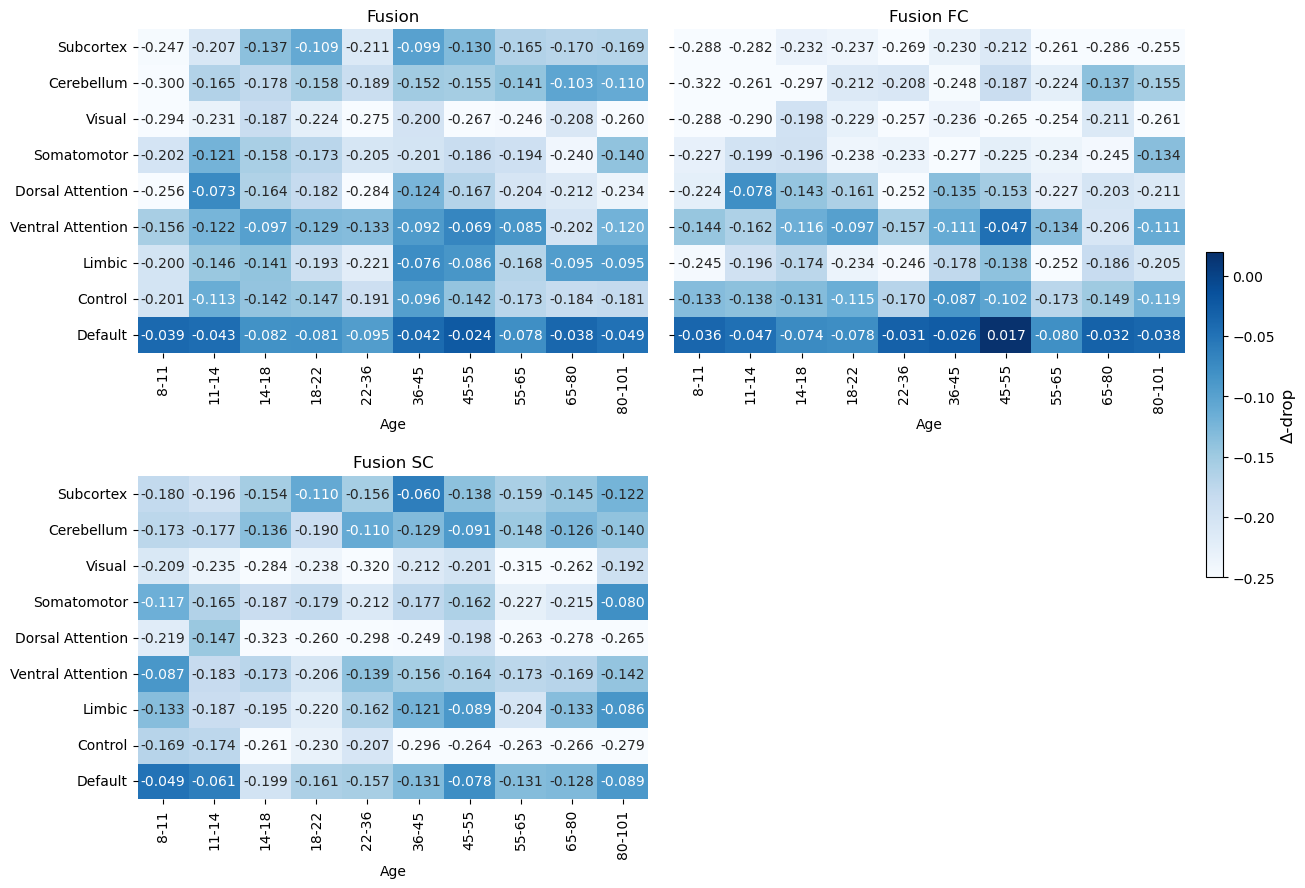

In [7]:
plot_three_heatmaps(fusion_df, fc_df, sc_df)

### Bar plot

look at significant linear/quadratic trends

In [11]:
def barplot_sensitivity_include_with_lines_and_marks(
    inc_fusion, inc_fusionFC, inc_fusionSC, *,
    group_labels1, include_ylim, include_bias, exclude_bias,
    alpha=0.05):
    networks = ['Subcortex', 'Cerebellum', 'Visual', 'Somatomotor',
                'Dorsal Attention', 'Ventral Attention',
                'Limbic', 'Control', 'Default']
    networks_short = ['SUB', 'CBL', 'VIS', 'SMN', 'DAN', 'VAN', 'LIM', 'CON', 'DMN']
    n_net      = len(networks)
    bar_width  = 0.11
    intra_gap  = 0.03
    group_gap  = 0.7
    x_centres  = np.arange(n_net) * (1 + group_gap)
    total_w    = len(group_labels1)*bar_width + (len(group_labels1)-1)*intra_gap

    mycolors = ['#000080', '#1F5B94', '#4585B3', '#75ABCA',
                '#5e9a5c', '#9ebf92', '#EDB8B0', '#E69191',
                '#C25759', '#A52A2A', '#800000']

    fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharey='col')

    # Reordered panels: Fusion FC → Fusion SC → Fusion
    panel_data = [
        (inc_fusionFC,  'Fusion FC', "test_acc_FC"),
        (inc_fusionSC,  'Fusion SC', "test_acc_SC"),
        (inc_fusion,    'Fusion',    "test_acc_fusion"),
    ]

    for ax, (df_plot, title, metric) in zip(axes.ravel(), panel_data):

        # ---- BAR PLOTS ----
        for i, age_bin in enumerate(group_labels1):
            offs = x_centres - total_w/2 + i*(bar_width + intra_gap) + bar_width/2
            ax.bar(
                offs, df_plot[age_bin] + include_bias,
                width=bar_width,
                label=age_bin if ax is axes[0] else None,
                color=mycolors[i % len(mycolors)]
            )

        # ---- FIT LINES + STAR MARKS ----
        for j, net in enumerate(networks):
            yvals = df_plot.iloc[j].values
            if len(yvals) <= 3:
                continue

            x = np.arange(len(group_labels1), dtype=float)
            y = yvals.copy()

            # (1) Linear / monotonic significance (Spearman)
            rho, p_spear = spearmanr(x, y)

            # (2) Quadratic significance
            X = np.column_stack([x, x**2])
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            p_quad = float(model.pvalues[2]) if len(model.pvalues) > 2 else 1.0

            sig_linear = p_spear < alpha
            sig_quad   = p_quad  < alpha
            if not (sig_linear or sig_quad):
                continue

            # smooth fit (optional visual line)
            xx = np.linspace(x.min(), x.max(), 100)
            if sig_quad:
                # Quadratic polynomial fit (degree 2)
                coeffs = np.polyfit(x, y, 2)
                yy = np.polyval(coeffs, xx)
            else:
                # Linear polynomial fit (degree 1)
                coeffs = np.polyfit(x, y, 1)
                yy = np.polyval(coeffs, xx)

            # map x to network cluster span
            span_start = x_centres[j] - total_w/2 + bar_width/2 + 0.04
            span_end   = x_centres[j] + total_w/2 - bar_width/2 + 0.04
            xx_scaled = span_start + (xx - x.min())/(x.max()-x.min()) * (span_end - span_start)

            # baseline offset for plotting under bars
            y_offset = -0.055 if metric in ['test_acc_FC'] else -0.09
            ax.plot(xx_scaled, yy + y_offset, color='black', linewidth=1, alpha=0.6)

            # ---- STAR MARKS ----
            x_pos = x_centres[j]
            y_star = (yy + y_offset).min() - 0.005  # default distance below line

            # sex only
            # move green star closer for CON in Fusion SC panel
            if title == 'Fusion SC' and networks_short[j] == 'CON': 
                y_star = (yy + y_offset).min() + 0.03  
            if title == 'Fusion SC' and networks_short[j] == 'SMN': 
                y_star = (yy + y_offset).min() - 0.02   
            if title == 'Fusion FC' and networks_short[j] == 'CBL': 
                y_star = (yy + y_offset).min() + 0.03          
            if title == 'Fusion' and networks_short[j] == 'CBL': 
                y_star = (yy + y_offset).min() + 0.02  
   

            # assign color & marker type
            if sig_quad:
                star_color = 'red'
                p_val = p_quad
            else:
                star_color = 'green'
                p_val = p_spear

            # single * if 0.01 ≤ p < 0.05, double ** if p < 0.01
            mark = '*' if p_val >= 0.01 else '**'

            ax.text(x_pos, y_star, mark, color=star_color,
                    ha='center', va='top', fontsize=10, fontweight='bold')

        # ---- Cosmetics ----
        ax.axhline(0, color='black', lw=0.8)
        ax.set_title(title, fontsize=11.5)
        ax.set_xticks(x_centres)
        ax.set_xticklabels(networks_short, ha='center', fontsize=9)
        ax.margins(x=0.03)
        ax.set_ylim((-include_ylim, 0))
        ax.set_ylabel('Δ-drop', fontsize=10)

    # ---- LEGENDS ----
    # (1) Age-bin legend (right side)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Age bin',
               bbox_to_anchor=(1.06, 0.7), loc='upper center',
               frameon=False, fontsize=9)

    # (2) Star legend (bottom, horizontal, only * / ** colored)
    y_pos = -0.015  # vertical placement relative to figure
    fig.text(0.4, y_pos, "* / **", color='green', fontsize=11, fontweight='bold', ha='right')
    fig.text(0.41, y_pos, "  Linear association p<0.05/0.01", color='black', fontsize=10, ha='left')
    fig.text(0.39, y_pos-0.03, "* / **", color='red', fontsize=11, fontweight='bold', ha='right')
    fig.text(0.4, y_pos-0.03, "Quadratic association p<0.05/0.01", color='black', fontsize=10, ha='left')
    fig.text(0.01, 0.985, "a)", color='black', fontsize=14, ha='left')
    plt.tight_layout(rect=(0, 0.02, 1, 1))
    plt.show()

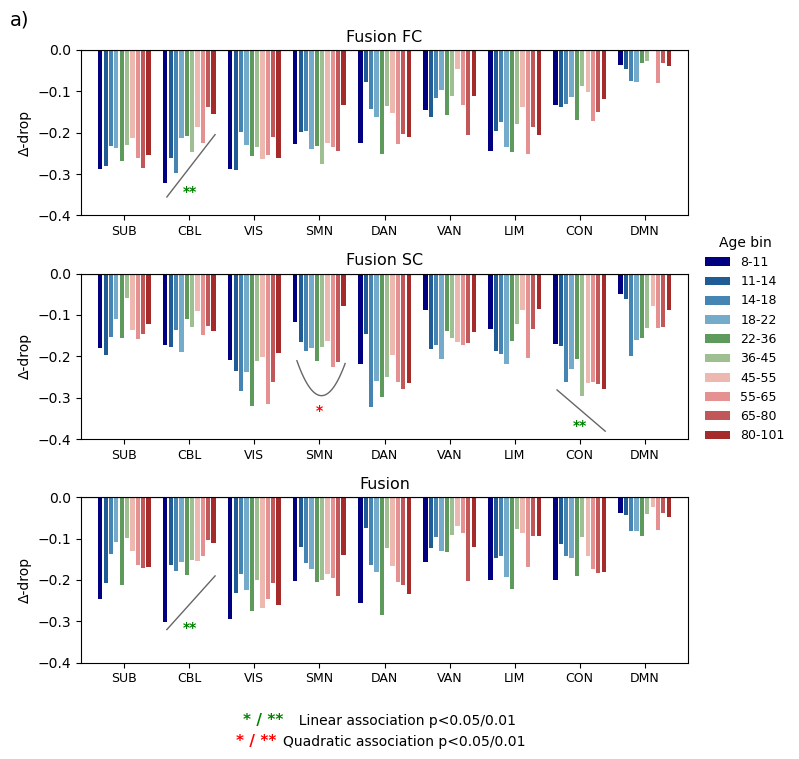

In [14]:
### sex only
barplot_sensitivity_include_with_lines_and_marks(
    inc_fusion=fusion_df,
    inc_fusionFC=fc_df,
    inc_fusionSC=sc_df,
    group_labels1=group_labels1,      # e.g. ['8-11','11-14',...,'80-101']
    include_ylim=0.4,            # set according to your Δ-drop scale
    include_bias=0.0,            # any bias you used in plotting
    exclude_bias=0.0,            # same here
    alpha=0.05                   # significance threshold
)

# Networkpair sensitivity analysis (Visualization)

In [ ]:
bins = [8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101] 
group_labels = ['[8,11)', '[11,14)', '[14,18)', '[18,22)', '[22,36)', '[36,45)', '[45, 55)', '[55, 65)' ,'[65, 80)', '[80,101)']
group_labels1 = ['8-11', '11-14', '14-18', '18-22', '22-36', '36-45', '45-55', '55-65', '65-80', '80-101']
with open('/home/out_log/results_HCPdata_Kraken/newYA95/sensitivity/results1110/sensitivity_sex_Krakencoder_[8, 11, 14, 18, 22, 36, 45, 55, 65, 80, 101]_stratifiedCV_split0328_test30_addnewYA_train_downsampledtrain30_nwpair.pkl', 'rb') as pickle_file:
    results = pickle.load(pickle_file)
yeopair_list = list(results['8-11'].keys())

In [16]:
d1 = len(yeopair_list) # number of include/exclude networks
d2 = len(results.keys()) # number of age groups

# Containers for averaged normalized values
acc_fusion = np.empty((d1, d2))
acc_fusionFC = np.empty((d1, d2))
acc_fusionSC = np.empty((d1, d2))

for age_idx, age_group in enumerate(group_labels1):
    # get baseline vector (100 reps) for INCLUDE:ALL (assumed to be yeopair_list[0])
    baseline_fusion   = np.array(results[age_group][yeopair_list[0]]['test_acc_fusion'])
    baseline_fusionFC = np.array(results[age_group][yeopair_list[0]]['test_acc_FC'])
    baseline_fusionSC = np.array(results[age_group][yeopair_list[0]]['test_acc_SC'])
    
    for yeopair_idx, yeopair in enumerate(yeopair_list):
        vals_fusion   = np.array(results[age_group][yeopair]['test_acc_fusion'])
        vals_fusionFC = np.array(results[age_group][yeopair]['test_acc_FC'])
        vals_fusionSC = np.array(results[age_group][yeopair]['test_acc_SC'])
        
        # Compute (x - baseline)/baseline for each rep, then average
        acc_fusion[yeopair_idx, age_idx]   = np.mean((vals_fusion   - baseline_fusion)   / baseline_fusion)
        acc_fusionFC[yeopair_idx, age_idx] = np.mean((vals_fusionFC - baseline_fusionFC) / baseline_fusionFC)
        acc_fusionSC[yeopair_idx, age_idx] = np.mean((vals_fusionSC - baseline_fusionSC) / baseline_fusionSC)

# Turn into DataFrames
acc_fusion   = pd.DataFrame(acc_fusion,   index=yeopair_list, columns=group_labels1)
acc_fusionFC = pd.DataFrame(acc_fusionFC, index=yeopair_list, columns=group_labels1)
acc_fusionSC = pd.DataFrame(acc_fusionSC, index=yeopair_list, columns=group_labels1)

include_net   = acc_fusion.copy()
includeFC_net = acc_fusionFC.copy()
includeSC_net = acc_fusionSC.copy()

# Drop baseline rows
include_net   = include_net.iloc[1:,:]
includeFC_net = includeFC_net.iloc[1:,:]
includeSC_net = includeSC_net.iloc[1:,:]

In [17]:
#for data_mask in [include_net, exclude_net]:
def change_index(data_mask):
    data_mask.index = data_mask.index.str.replace('INCLUDE:7Networks_', '', regex=False)
    data_mask.index = data_mask.index.str.replace('INCLUDE:', '', regex=False)
    data_mask.index = data_mask.index.str.replace('EXCLUDE:7Networks_', '', regex=False)
    data_mask.index = data_mask.index.str.replace('EXCLUDE:', '', regex=False)
    data_mask.index = data_mask.index.str.replace('7Networks_', '', regex=False)
    data_mask.index = data_mask.index.str.replace('SomMot', 'SMN', regex=False)
    data_mask.index = data_mask.index.str.replace('DorsAttn', 'DAN', regex=False)
    data_mask.index = data_mask.index.str.replace('SalVentAttn', 'VAN', regex=False)
    data_mask.index = data_mask.index.str.replace('Limbic', 'LIM', regex=False)
    data_mask.index = data_mask.index.str.replace('Cont', 'CON', regex=False)
    data_mask.index = data_mask.index.str.replace('Default', 'DMN', regex=False)
    data_mask.index = data_mask.index.str.replace('Subcortex', 'SUB', regex=False)
    data_mask.index = data_mask.index.str.replace('Cerebellum', 'CBL', regex=False)
    data_mask.index = data_mask.index.str.replace('Vis', 'VIS', regex=False)
    data_mask.index = data_mask.index.str.replace('<->', '-', regex=False)
    return data_mask

In [18]:
include_net = change_index(include_net)
includeFC_net = change_index(includeFC_net)
includeSC_net = change_index(includeSC_net)

In [20]:
###### include_net
include_net1 = include_net.loc[['SUB-SUB', 'SUB-CBL', 'VIS-SUB', 'SMN-SUB', 'DAN-SUB', 'VAN-SUB', 'LIM-SUB', 'CON-SUB', 'DMN-SUB',
                 'CBL-CBL', 'VIS-CBL', 'SMN-CBL', 'DAN-CBL', 'VAN-CBL', 'LIM-CBL', 'CON-CBL', 'DMN-CBL',
                 'VIS-VIS', 'VIS-SMN', 'VIS-DAN', 'VIS-VAN', 'VIS-LIM', 'VIS-CON', 'VIS-DMN',
                 'SMN-SMN', 'SMN-DAN', 'SMN-VAN', 'SMN-LIM', 'SMN-CON', 'SMN-DMN',
                 'DAN-DAN', 'DAN-VAN', 'DAN-LIM', 'DAN-CON', 'DAN-DMN',
                 'VAN-VAN', 'VAN-LIM', 'VAN-CON', 'VAN-DMN',
                 'LIM-LIM', 'LIM-CON', 'LIM-DMN',
                 'CON-CON', 'CON-DMN',
                 'DMN-DMN'],:]
includeFC_net1 = includeFC_net.loc[['SUB-SUB', 'SUB-CBL', 'VIS-SUB', 'SMN-SUB', 'DAN-SUB', 'VAN-SUB', 'LIM-SUB', 'CON-SUB', 'DMN-SUB',
                 'CBL-CBL', 'VIS-CBL', 'SMN-CBL', 'DAN-CBL', 'VAN-CBL', 'LIM-CBL', 'CON-CBL', 'DMN-CBL',
                 'VIS-VIS', 'VIS-SMN', 'VIS-DAN', 'VIS-VAN', 'VIS-LIM', 'VIS-CON', 'VIS-DMN',
                 'SMN-SMN', 'SMN-DAN', 'SMN-VAN', 'SMN-LIM', 'SMN-CON', 'SMN-DMN',
                 'DAN-DAN', 'DAN-VAN', 'DAN-LIM', 'DAN-CON', 'DAN-DMN',
                 'VAN-VAN', 'VAN-LIM', 'VAN-CON', 'VAN-DMN',
                 'LIM-LIM', 'LIM-CON', 'LIM-DMN',
                 'CON-CON', 'CON-DMN',
                 'DMN-DMN'],:]
includeSC_net1 = includeSC_net.loc[['SUB-SUB', 'SUB-CBL', 'VIS-SUB', 'SMN-SUB', 'DAN-SUB', 'VAN-SUB', 'LIM-SUB', 'CON-SUB', 'DMN-SUB',
                 'CBL-CBL', 'VIS-CBL', 'SMN-CBL', 'DAN-CBL', 'VAN-CBL', 'LIM-CBL', 'CON-CBL', 'DMN-CBL',
                 'VIS-VIS', 'VIS-SMN', 'VIS-DAN', 'VIS-VAN', 'VIS-LIM', 'VIS-CON', 'VIS-DMN',
                 'SMN-SMN', 'SMN-DAN', 'SMN-VAN', 'SMN-LIM', 'SMN-CON', 'SMN-DMN',
                 'DAN-DAN', 'DAN-VAN', 'DAN-LIM', 'DAN-CON', 'DAN-DMN',
                 'VAN-VAN', 'VAN-LIM', 'VAN-CON', 'VAN-DMN',
                 'LIM-LIM', 'LIM-CON', 'LIM-DMN',
                 'CON-CON', 'CON-DMN',
                 'DMN-DMN'],:]

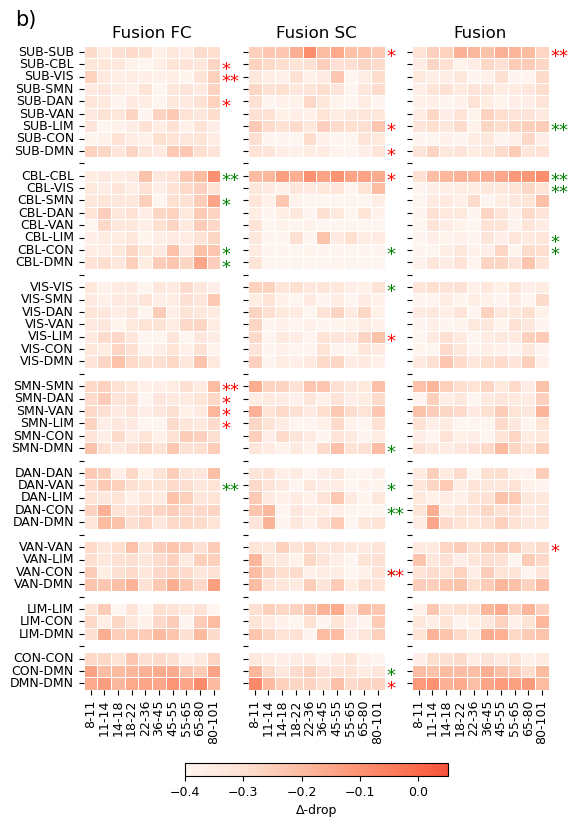

In [ ]:
# ---------- Statistical tests ----------
def test_monotonic(y, ages):
    """Spearman rank correlation test."""
    rho, p = spearmanr(ages, y, nan_policy="omit")
    return rho, p

def test_quadratic(y, ages):
    """Quadratic regression: y ~ age + age^2"""
    ages = np.asarray(ages)
    X = np.column_stack([ages, ages**2])
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing="drop").fit()
    # test if quadratic term significant
    p_quad = model.pvalues[2] if len(model.pvalues) > 2 else 1.0
    return p_quad

# ---------- add gaps ----------
def add_gap_rows(df, segments):
    pieces = []
    start = 0
    for seg in segments:
        pieces.append(df.iloc[start:start+seg, :])
        blank = pd.DataFrame(
            np.nan,
            index=[f"gap_{start+seg}"],
            columns=df.columns
        )
        pieces.append(blank)
        start += seg
    pieces.pop()  # drop trailing gap
    return pd.concat(pieces, axis=0)

# ---------- prepared data ----------
segments = [9, 8, 7, 6, 5, 4, 3, 3]
datasets = [
    (includeFC_net1,"Fusion FC"),
    (includeSC_net1,"Fusion SC"),
        (include_net1,  "Fusion")
]

age_ranks = np.arange(len(include_net1.columns))  # numeric encoding of age bins

# ---------- Run significance tests ----------
sig_dict = {}  # {(modality, netpair): {"mono":pval, "quad":pval}}

for df, title in datasets:
    for netpair, row in df.iterrows():
        y = row.values.astype(float)
        rho, p_mono = test_monotonic(y, age_ranks)
        p_quad = test_quadratic(y, age_ranks)

        sig_dict[(title, netpair)] = {"mono": p_mono, "quad": p_quad}

# ---------- Plotting ----------
fig, axes = plt.subplots(1, 3, figsize=(6, 10), sharey=True, sharex=True)

heat_kwargs = dict(
    cmap="Reds",
    center=0,
    mask=None,
    linewidths=0.5,
    linecolor="white",
    xticklabels=True,
    yticklabels=True,
    cbar=False,
    vmin=-0.4,
    vmax=0.05
)

for ax, (df, title) in zip(axes, datasets):
    combined = add_gap_rows(df, segments)
    heat_kwargs["mask"] = combined.isna()
    im = sns.heatmap(combined, ax=ax, **heat_kwargs)

    # X-ticks (age bins)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

    # Y-tick relabeling
    new_yticks = []
    for lbl in combined.index:
        if lbl.startswith("gap_"):
            new_yticks.append("")
        else:
            left, right = lbl.split("-", 1)
            if right == "SUB":
                new_yticks.append(f"SUB-{left}")
            elif right == "CBL" and left != "SUB":
                new_yticks.append(f"CBL-{left}")
            else:
                new_yticks.append(lbl)
    ax.set_yticklabels(new_yticks, rotation=0)
    ax.tick_params(axis='y', labelsize=9)
    ax.tick_params(axis='x', labelsize=9)
    ax.set_title(title, fontsize=12)

    # --- Add stars for significance ---
    for row_idx, netpair in enumerate(combined.index):
        if netpair.startswith("gap_"):
            continue
        key = (title, netpair)
        if key in sig_dict:
            p_mono = sig_dict[key]["mono"]
            p_quad = sig_dict[key]["quad"]

            # Monotonic
            if p_mono < 0.01:
                ax.text(len(df.columns)+0.1, row_idx+0.9, "**",
                        va="center", ha="left", fontsize=13, color="green")
            elif p_mono < 0.05:
                ax.text(len(df.columns)+0.1, row_idx+0.9, "*",
                        va="center", ha="left", fontsize=13, color="green")

            # Quadratic
            if p_quad < 0.01:
                ax.text(len(df.columns)+0.1, row_idx+0.9, "**",
                        va="center", ha="left", fontsize=13, color="red")
            elif p_quad < 0.05:
                ax.text(len(df.columns)+0.1, row_idx+0.9, "*",
                        va="center", ha="left", fontsize=13, color="red")

# ---------- Shared colorbar ----------
fig.subplots_adjust(bottom=0.15)
cbar = fig.colorbar(
    im.collections[0],
    ax=axes,
    orientation="horizontal",
    fraction=0.018,
    pad=0.1
)
cbar.set_label("Δ-drop", fontsize=9)
cbar.ax.tick_params(labelsize=9)
fig.text(0.01, 0.9, "b)", color='black', fontsize=15, ha='left')
plt.show()


### heatmap with exact values

In [ ]:
import re
networks = ['SUB', 'CBL', 'VIS', 'SMN', 'DAN', 'VAN', 'LIM', 'CON', 'DMN']

def sensi_network_pair(mask_data, v_min_, v_max_, color, title, bins = bins): 
    n_bins = len(bins)-1 
    fig, axes = plt.subplots(3, 4, figsize=(25, 10))  # adjust as needed
    axes = axes.flatten() 
    for i in range(n_bins): 
        matrix = pd.DataFrame(np.nan, index=networks, columns=networks)
        for idx, row in mask_data.iterrows():
            include_text = row.name  # first column (the string)
            value = row[group_labels1[i]]         # second column (the value)
            match = re.match(r"(.*)-(.*)", include_text)
            if match:
                source, target = match.groups()
                if source in networks and target in networks:
                    matrix.loc[source, target] = value
        matrix.iloc[0, 2:] = matrix.iloc[2:,0]
        matrix.iloc[1, 2:] = matrix.iloc[2:,1]
        final_df = matrix.where(~np.tril(np.ones((9,9)), -1).astype(bool), matrix.T)

        bin_label = f"{bins[i]}-{bins[i+1]}"
        ax = axes[i]
        mask = np.tril(np.ones_like(final_df, dtype=bool), k=-1)
        sns.heatmap(final_df, mask=mask, annot=True, cmap=color, vmin=v_min_, vmax=v_max_, fmt=".3f", cbar=False, ax=ax)
        ax.set_title(bin_label)

    for j in range(n_bins, len(axes)):
        axes[j].axis('off')

    sm = cm.ScalarMappable(norm=colors.Normalize(vmin=v_min_, vmax=v_max_), cmap=color)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes, fraction=0.007, pad=0.008)
    cbar.set_label("Δ-drop", fontsize = 12)
    fig.tight_layout(rect=[0, 0, 0.89, 1])   # leave room on the right
    fig.suptitle(title, fontsize=15, y=1.02)
    plt.show()

In [24]:
#for data_mask in [include_net, exclude_net]:
def change_index(data_mask):
    data_mask.index = data_mask.index.str.replace('INCLUDE:7Networks_', '', regex=False)
    data_mask.index = data_mask.index.str.replace('INCLUDE:', '', regex=False)
    data_mask.index = data_mask.index.str.replace('EXCLUDE:7Networks_', '', regex=False)
    data_mask.index = data_mask.index.str.replace('EXCLUDE:', '', regex=False)
    data_mask.index = data_mask.index.str.replace('7Networks_', '', regex=False)
    data_mask.index = data_mask.index.str.replace('SomMot', 'SMN', regex=False)
    data_mask.index = data_mask.index.str.replace('DorsAttn', 'DAN', regex=False)
    data_mask.index = data_mask.index.str.replace('SalVentAttn', 'VAN', regex=False)
    data_mask.index = data_mask.index.str.replace('Limbic', 'LIM', regex=False)
    data_mask.index = data_mask.index.str.replace('Cont', 'CON', regex=False)
    data_mask.index = data_mask.index.str.replace('Default', 'DMN', regex=False)
    data_mask.index = data_mask.index.str.replace('Subcortex', 'SUB', regex=False)
    data_mask.index = data_mask.index.str.replace('Cerebellum', 'CBL', regex=False)
    data_mask.index = data_mask.index.str.replace('Vis', 'VIS', regex=False)
    data_mask.index = data_mask.index.str.replace('<->', '-', regex=False)
    return data_mask

include_net = change_index(include_net)
includeFC_net = change_index(includeFC_net)
includeSC_net = change_index(includeSC_net)

/tmp/ipykernel_4096129/1975923395.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.89, 1])   # leave room on the right


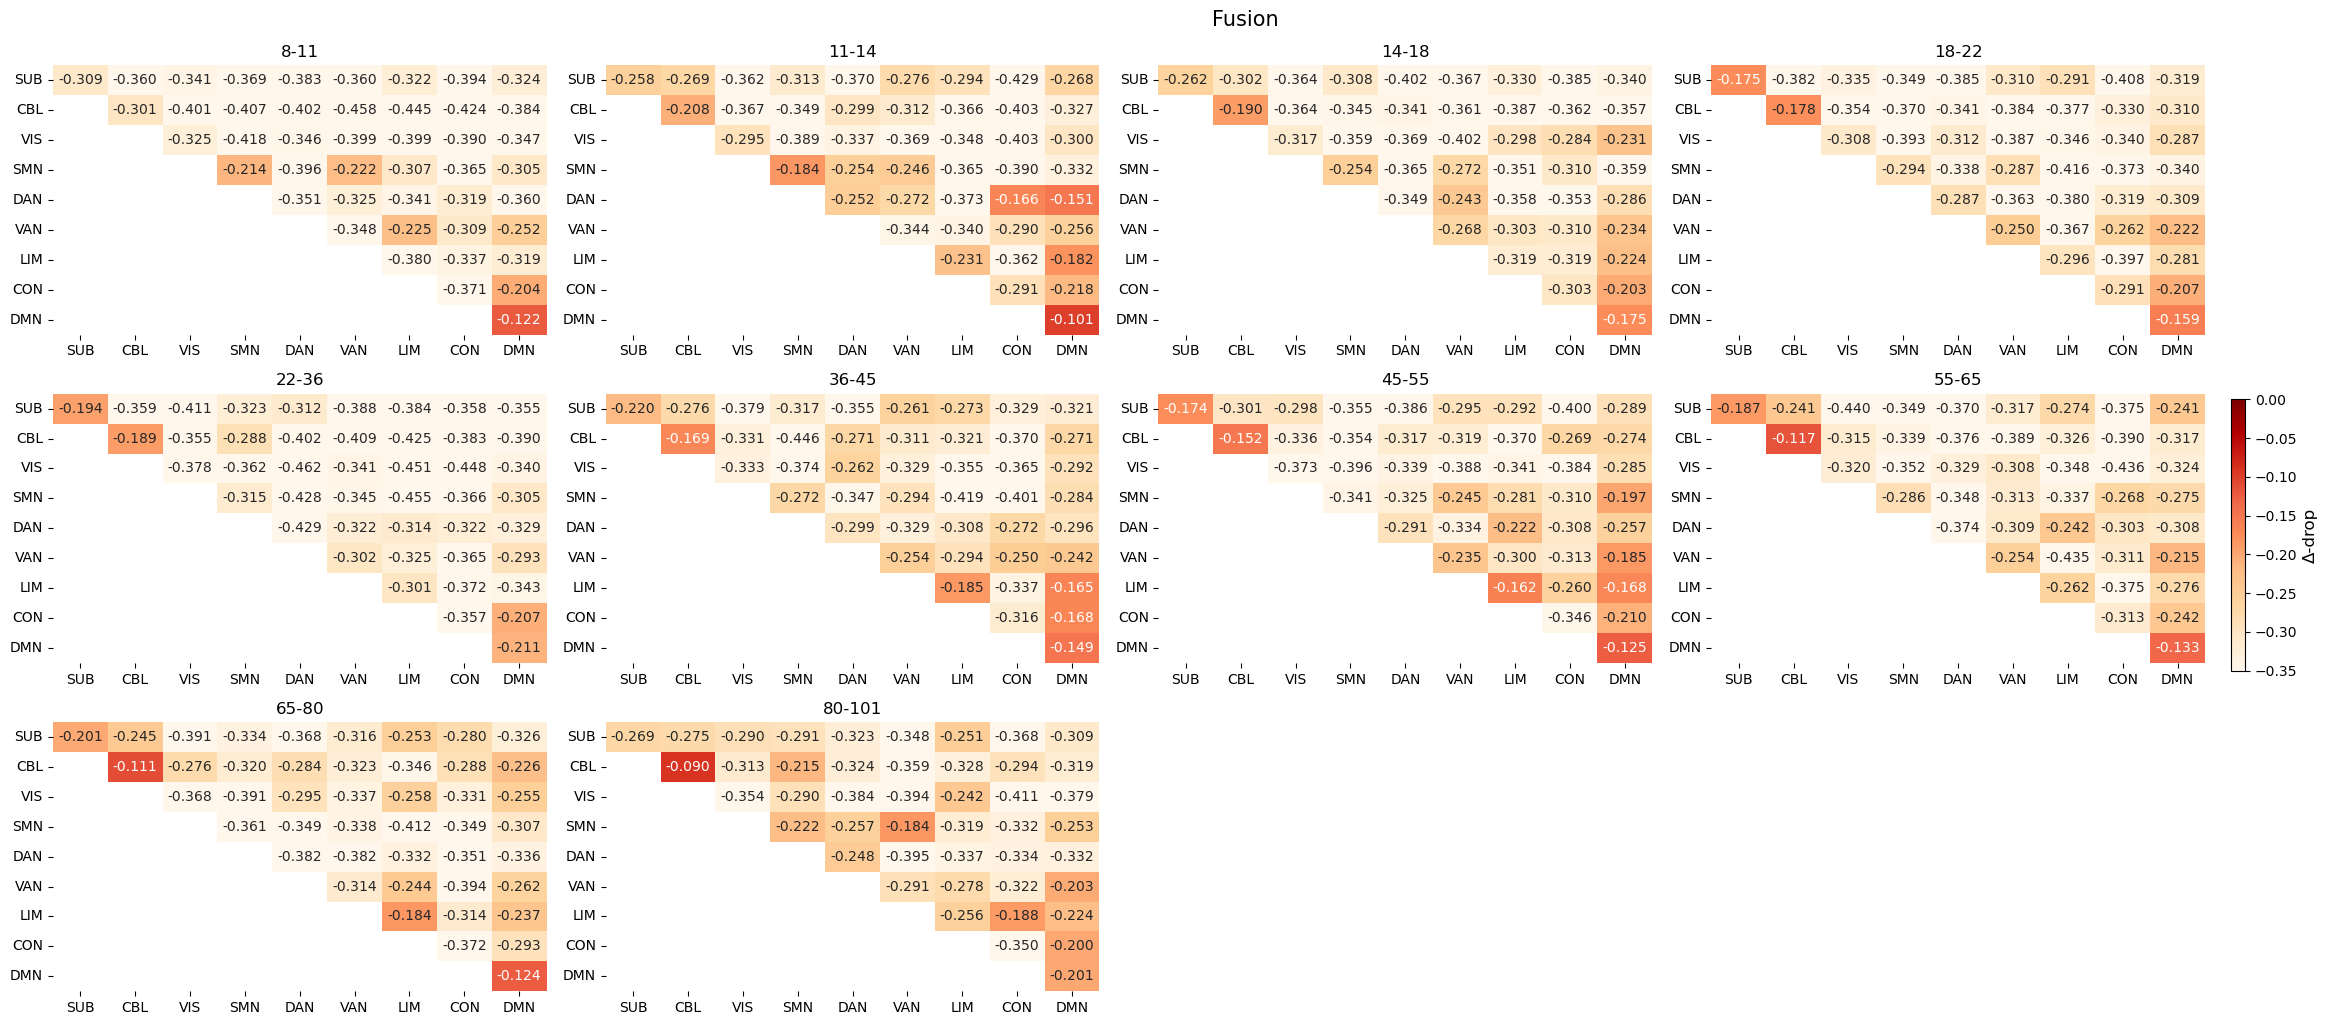

In [25]:
sensi_network_pair(include_net, -0.35, 0, "OrRd", 'Fusion')

/tmp/ipykernel_4096129/1975923395.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.89, 1])   # leave room on the right


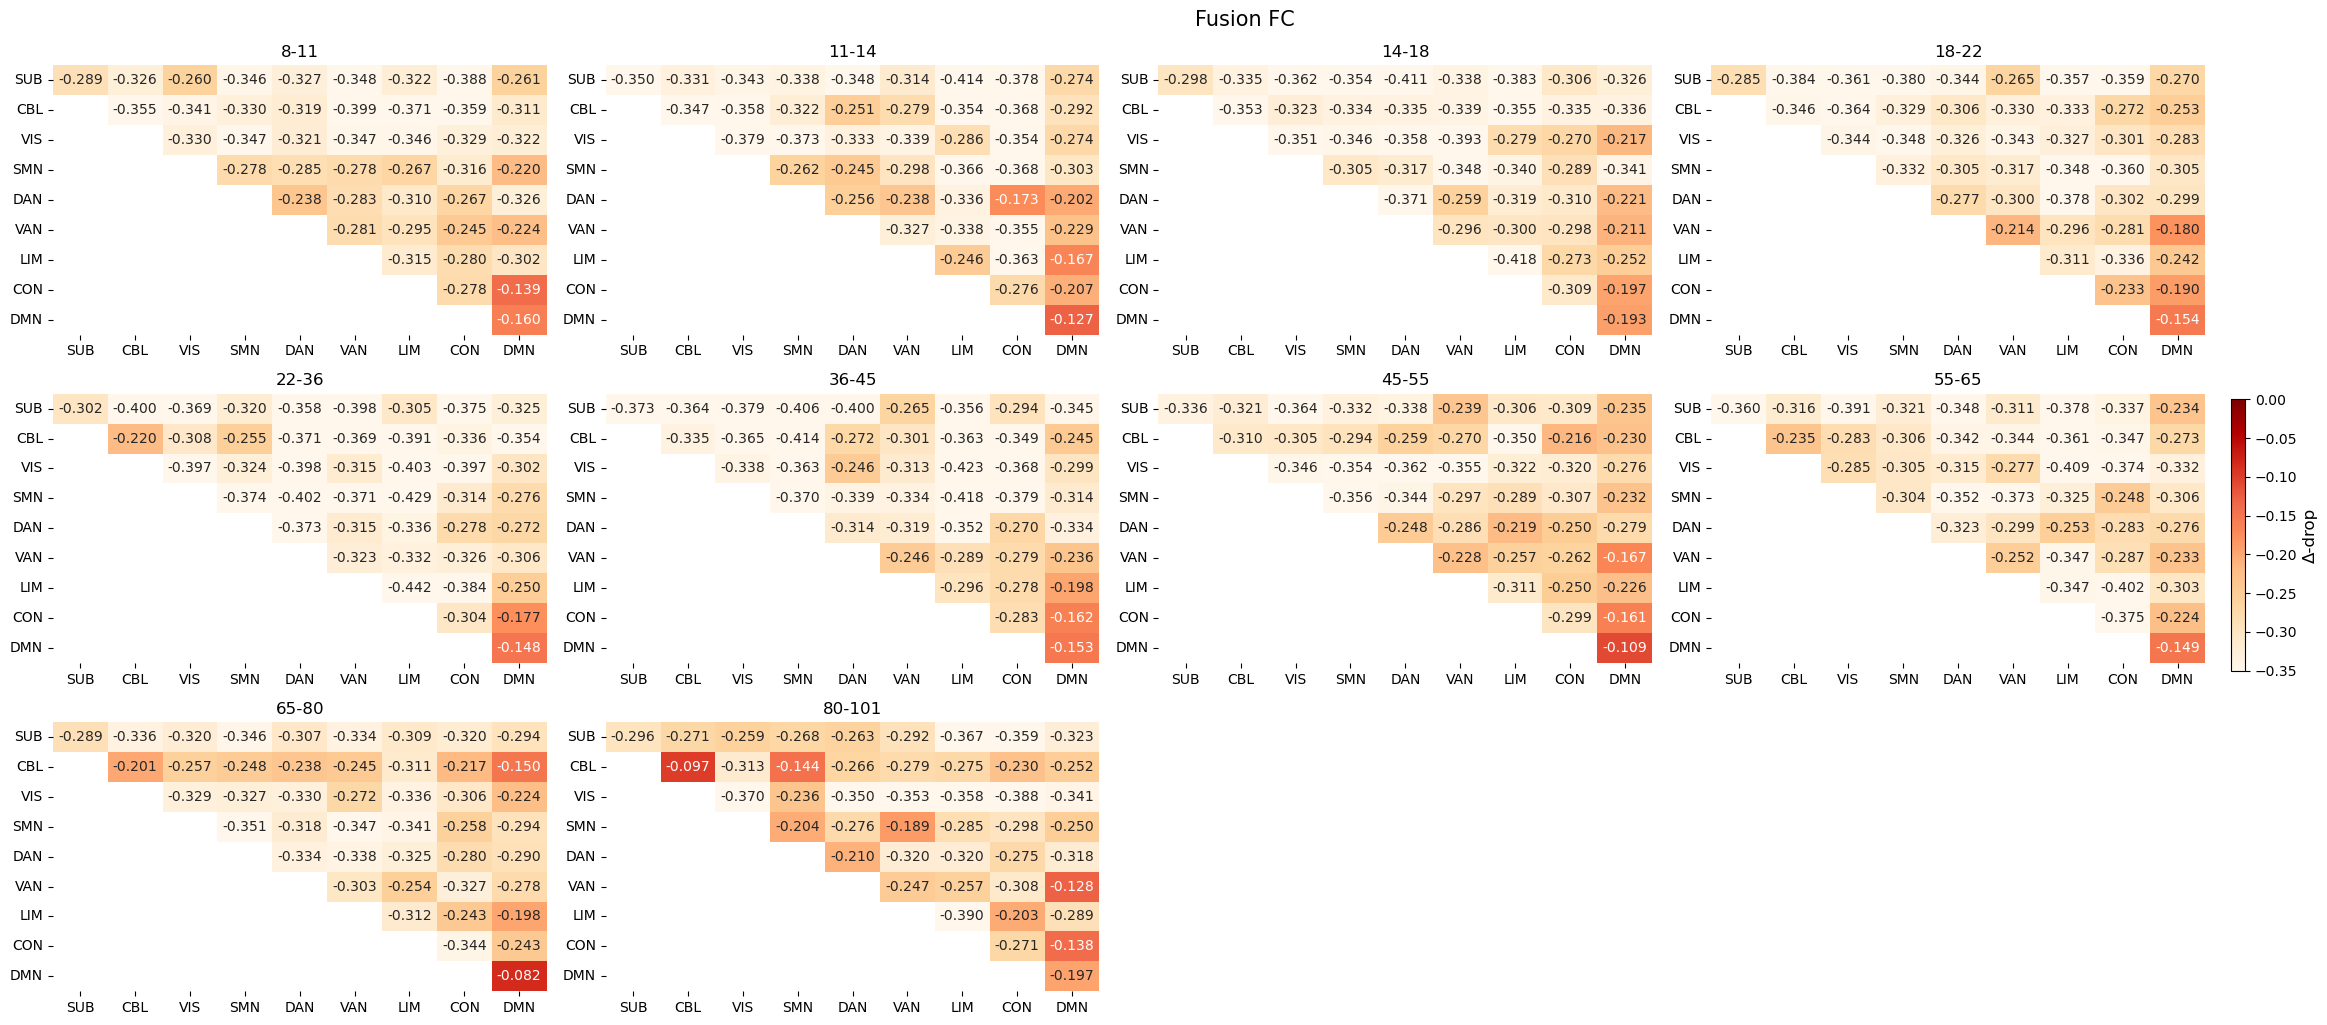

In [26]:
sensi_network_pair(includeFC_net, -0.35, 0, "OrRd", 'Fusion FC')

/tmp/ipykernel_4096129/1975923395.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.89, 1])   # leave room on the right


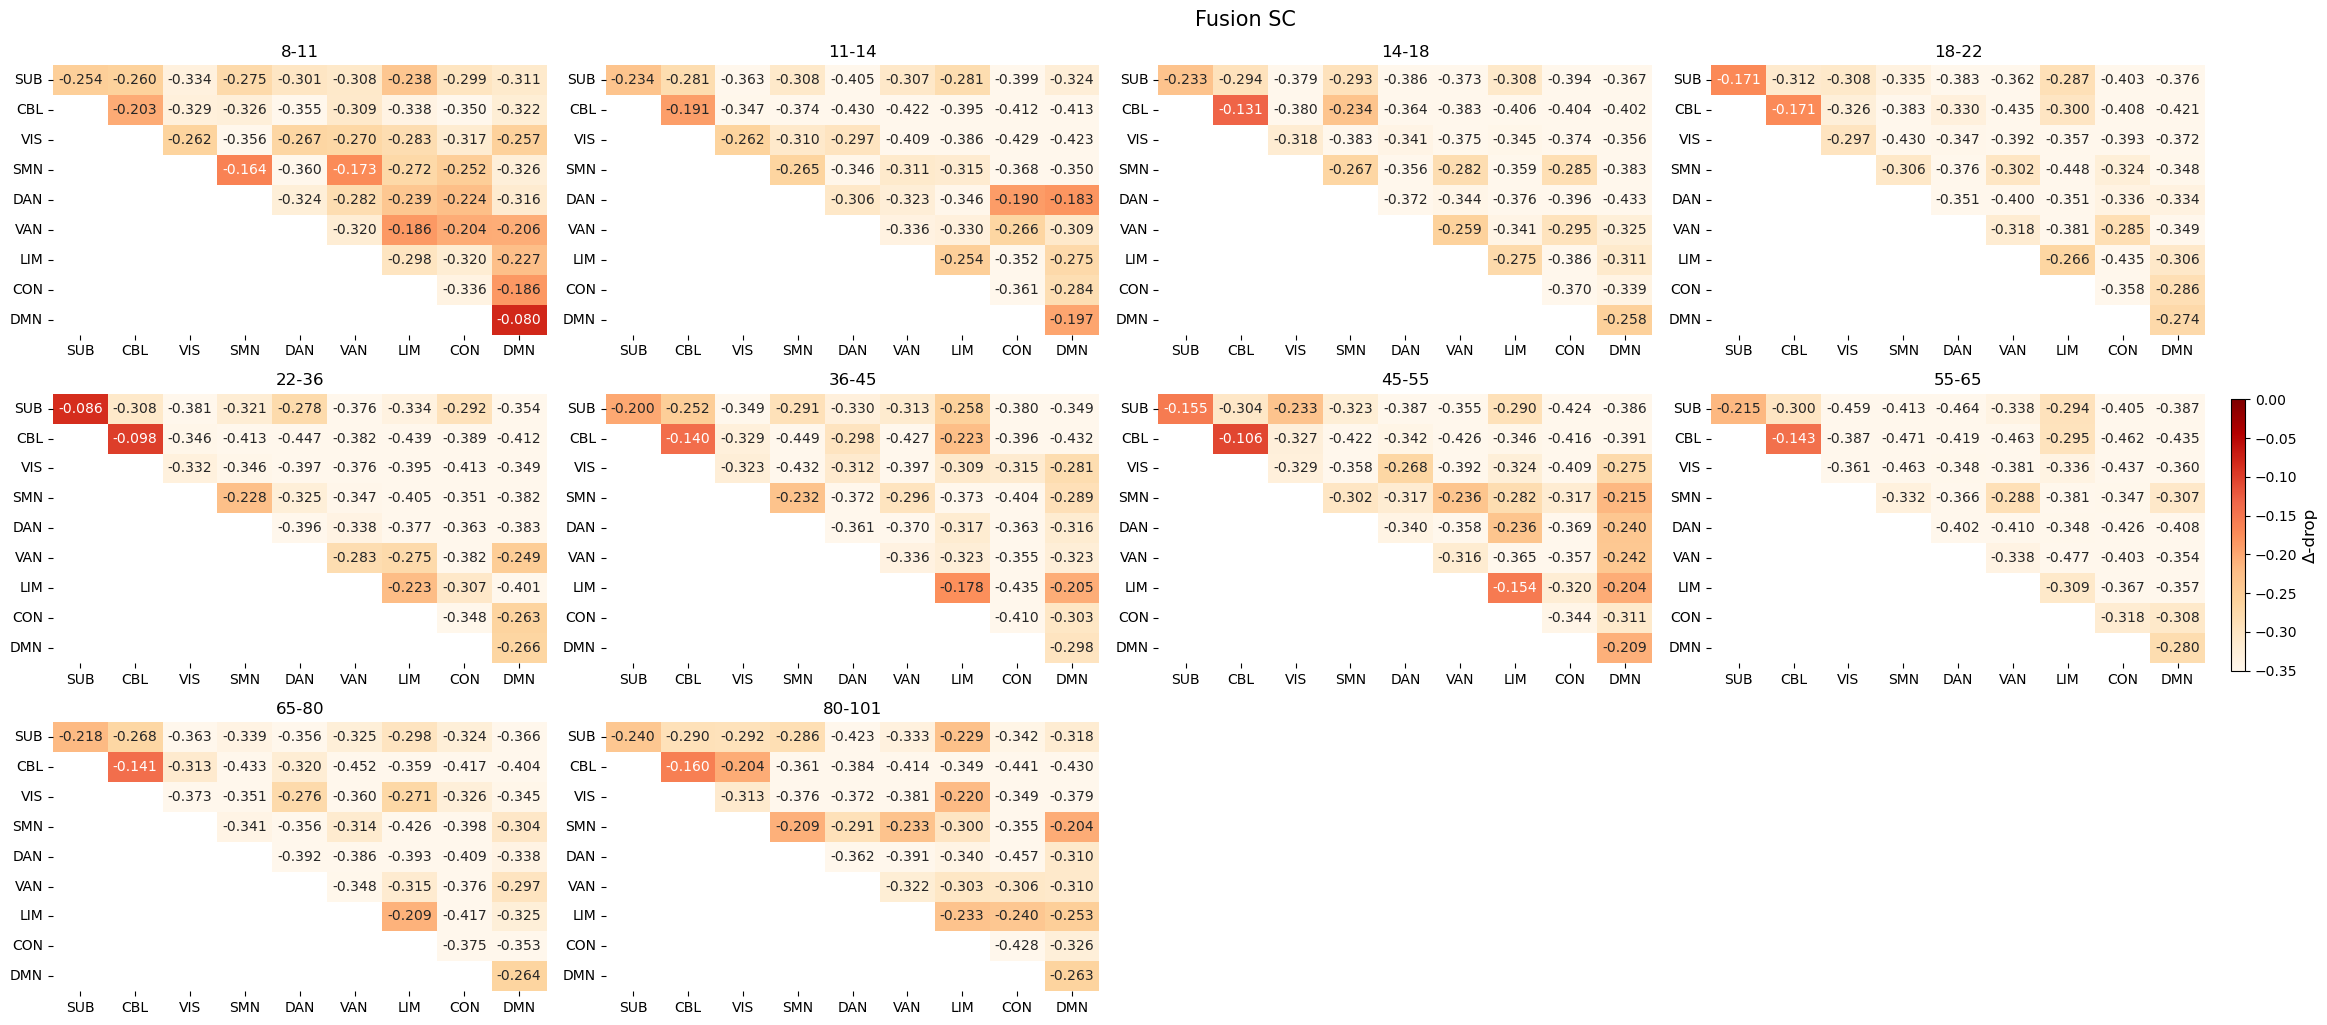

In [27]:
sensi_network_pair(includeSC_net, -0.35, 0, "OrRd", 'Fusion SC')